In [6]:
# python3
# coding: utf-8

"""
CS7641 - Assignment 3 Multilayer Perception Analysis

Mike Tong


Created: MAR 2019
"""

import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from sklearn.random_projection import GaussianRandomProjection as GRP

from ancillary import measure_execution_time, prep_data_for_clf, plot_learning_curve

In [2]:
class MLPC_Analysis(object):
    def __init__(self, dataset, target, save=False, random_state=7308):
        self.data = dataset
        self.target = target
        self.save = save
        self.random = random_state

    def general_analysis(self):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            print("\n######")
            print("Multilayer Perceptron Classifier:")
            print('Default Baseline values\n')

            clf = MLPClassifier(random_state=self.random, max_iter=1000,)
            plot_learning_curve(clf, '{} MLP Learning Curve'.format(
                self.data.index.name), self.data, self.target, cv=5, scale=True)

            print("\n~~~~~~")
            print("Execution time metrics")
            X_train, X_test, y_train, y_test = prep_data_for_clf(
                self.data, self.target, random_state=self.random)

            sclr = StandardScaler()
            sclr.fit(X_train.astype('float'))
            X_train_std = sclr.transform(X_train.astype('float'))
            X_test_std = sclr.transform(X_test.astype('float'))
            training_time, testing_time = measure_execution_time(clf,
                pd.concat([pd.DataFrame(X_train_std), pd.DataFrame(X_test_std)]), pd.concat([y_train, y_test])
                )
            print("Training time input dim of {} : {:.4f} (+/- {:.4f})".format(
                X_train.shape, np.mean(training_time), np.std(training_time))
                )
            print("Testing time input dim of {}: {:.4f} (+/- {:.4f})".format(
                X_test.shape, np.mean(testing_time), np.std(testing_time))
                )

            print("\n~~~~~~")
            scores = cross_val_score(clf,
                pd.concat([pd.DataFrame(X_train_std), pd.DataFrame(X_test_std)]), pd.concat([y_train, y_test]),
                    cv=10, n_jobs=-1)

            print("10 Fold Cross Validation Accuracy: {:.4f} (+/- {:.4f})".format(
                scores.mean(), scores.std() * 2))

            clf.fit(X_train_std, y_train)
            preds_train = clf.predict(X_train_std)
            preds_test = clf.predict(X_test_std)

            print("Training Accuracy:",
                accuracy_score(y_true=y_train, y_pred=preds_train))
            print("Training F1:",
                f1_score(y_true=y_train, y_pred=preds_train, average='weighted'))
            print("Testing Accuracy:",
                accuracy_score(y_true=y_test, y_pred=preds_test))
            print("Testing F1:",
                f1_score(y_true=y_test, y_pred=preds_test, average='weighted'))
            print('~~~~~~\n')

    def max_iteration_analysis(self, range_=range(100, 1100, 100)):
        print("\n######")
        print("Testing different max iterations.")
        metrics = defaultdict(list)
        X_train, X_test, y_train, y_test = prep_data_for_clf(
            self.data, self.target, random_state = self.random)

        sclr = StandardScaler()
        sclr.fit(X_train.astype('float'))
        X_train_std = sclr.transform(X_train.astype('float'))
        X_test_std = sclr.transform(X_test.astype('float'))

        for r in range_:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                clf = MLPClassifier(random_state=self.random, max_iter=r)
                clf.fit(X_train, y_train)

                preds_train = clf.predict(X_train_std)
                preds_test = clf.predict(X_test_std)

                metrics['train_acc'].append(
                    accuracy_score(y_true=y_train, y_pred=preds_train))
                metrics['test_acc'].append(
                    accuracy_score(y_true=y_test, y_pred=preds_test))

        results = pd.DataFrame(metrics, index=range_)
        results.index.name = "max_iter"

        plt.gcf().set_size_inches(8, 5)
        for col in metrics:
            plt.plot(range_, metrics[col], 'o-')
        plt.legend(['Training', 'Testing'], ncol=1, loc=4)

        plt.xlabel('Max Number of Iterations')
        plt.ylabel('Accuracy Score (weighted)')
        plt.xticks(range_, rotation=45)
        plt.title('MLPC Train and Test Accuracy for {}'.format(
            self.data.index.name))

        plt.grid()
        plt.show()

        self.best_iter= results['test_acc'].idxmax()

        if self.save:
            results.to_csv("./results/MLPC/{}_max_iter_analysis.csv".format(
                self.data.index.name))

        return results

    def hidden_layer_analysis(self, range_ = range(2,11)):
        print("\n######")
        print("Testing Different Node Numbers via Alpha Parameter")
        metrics = defaultdict(list)
        X_train, X_test, y_train, y_test = prep_data_for_clf(
            self.data, self.target, random_state=self.random)

        sclr = StandardScaler()
        sclr.fit(X_train.astype('float'))
        X_train_std = sclr.transform(X_train.astype('float'))
        X_test_std = sclr.transform(X_test.astype('float'))

        num_hidden_layers = []
        for alpha in range_:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
#                 hidden = self.num_hidden(self.data, 3, alpha)
                hidden = alpha
                num_hidden_layers.append(hidden)

                clf = MLPClassifier(hidden_layer_sizes=(hidden, 2), max_iter=1000,
                early_stopping=True, random_state=self.random)

                clf.fit(X_train_std, y_train)
                preds_train = clf.predict(X_train_std)
                preds_test = clf.predict(X_test_std)

                metrics['train_acc'].append(
                    accuracy_score(y_true=y_train, y_pred=preds_train))
                metrics['test_acc'].append(
                    accuracy_score(y_true=y_test, y_pred=preds_test))

        results = pd.DataFrame(metrics, index=num_hidden_layers)
        results['alpha'] = range_
        results.index.name = "n_hidden"

        self.plot_hl(num_hidden_layers, stats=results,
        	     plt_title='MLPC Train and Test Accuracy for {}'.format(
                    self.data.index.name))
        self.best_n_nodes = results['test_acc'].idxmax()
        if self.save:
            results.to_csv("./results/MLPC/{}_hidden_layer_analysis.csv".format(
            self.data.index.name))

        return results

    def activation_analysis(self):
        print("\n######")
        print("Testing Different Activation Functions with 10 Fold X-Val")
        X_train, X_test, y_train, y_test = prep_data_for_clf(self.data, self.target, random_state=self.random)

        sclr = StandardScaler()
        sclr.fit(X_train.astype('float'))
        X_train_std = sclr.transform(X_train.astype('float'))
        X_test_std = sclr.transform(X_test.astype('float'))

        activations = ['identity', 'logistic', 'tanh', 'relu']
        # n_outputs = self.data[self.target].nunique()
        try:
            hidden = self.best_n_nodes
        except:
            hidden = self.num_hidden(self.data, 3, 4)

        accuracy = []
        stdev = []

        for activation in activations:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                clf = MLPClassifier(activation=activation,
                    hidden_layer_sizes=(hidden, 2), max_iter=1000,
                    early_stopping=True,
                    random_state=self.random)

                scores = cross_val_score(clf,
                    pd.concat([pd.DataFrame(X_train_std), pd.DataFrame(X_test_std)]), pd.concat([y_train, y_test]),
                    cv=10, n_jobs=-1)

                accuracy.append(scores.mean())
                stdev.append(scores.std() * 2)

        results = pd.DataFrame(index=activations,
            data=np.array([accuracy, stdev]).T,
            columns=['acc', 'std'])

        if self.save:
            results.to_csv("./results/MLPC/{}_MLPC_activation_analysis.csv".format(
                self.data.index.name)
                )

        return results

    def num_hidden(self, df, classes, alpha):
        """
        From: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/1097#1097
        """
        return round(df.shape[0]/(alpha * (df.shape[1] + classes)))

    def plot_hl(self, hidden_layers, stats, plt_title):
        plt.gcf().set_size_inches(8, 5)
        for col in stats.drop(columns=['alpha'], axis=1):
            plt.plot(hidden_layers, stats[col], 'o-')
        plt.legend(['Training', 'Testing'], ncol=1, loc=4)

        plt.xlabel('Number of Hidden Units')
        plt.ylabel('Accuracy Score (weighted)')
        plt.xticks(hidden_layers)
        plt.title(plt_title)

        plt.grid()
        plt.show()


In [39]:
df_main = pd.read_csv("./assets/cleaned_student_data.csv")
X_student = df_main.iloc[:, :-1]
y_student = df_main.iloc[:, -1]

df_main = pd.read_csv("./assets/cleaned_housing_data.csv")
X_housing = df_main.iloc[:, :-1].astype('float')
y_housing = df_main.iloc[:, -1]
re_label = dict(zip(y_housing.unique()[::-1], range(y_housing.unique().size)))  # convert 'Group x' to int
y_housing = y_housing.replace(re_label) 

In [4]:
X, y = X_student.copy(), y_student
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

transformer = PCA(n_components=5, random_state=7308)
X_pca = transformer.fit_transform(X_std)

transformer = ICA(n_components=5, random_state=7308)
X_ica = transformer.fit_transform(X_std)

transformer = GRP(n_components=5, random_state=7308)
X_grp = transformer.fit_transform(X_std)

transformer = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=5)
X_gup = transformer.fit_transform(X_std, y)

results = []
for xs in [X_pca, X_ica, X_grp, X_gup]:
    dataset = pd.DataFrame(np.concatenate([xs, y[:, np.newaxis]], 1))
    dataset.rename(columns={dataset.shape[1]-1 : 'target'}, inplace=True)
    dataset.index.name = 'Student Dataset'
    results.append(dataset)


######
Multilayer Perceptron Classifier:
Default Baseline values



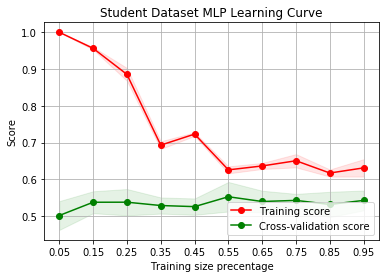


~~~~~~
Execution time metrics
Training time input dim of (800, 5) : 0.5592 (+/- 0.1443)
Testing time input dim of (200, 5): 0.0015 (+/- 0.0004)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5449 (+/- 0.0855)
Training Accuracy: 0.6325
Training F1: 0.6317807858289843
Testing Accuracy: 0.5
Testing F1: 0.4950020399836801
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


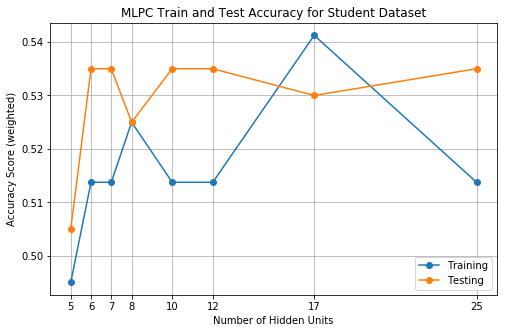


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



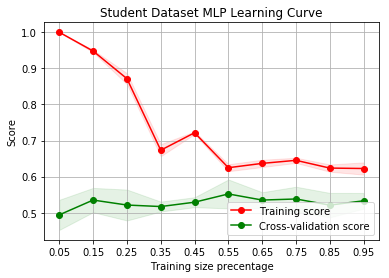


~~~~~~
Execution time metrics
Training time input dim of (800, 5) : 0.7376 (+/- 0.1067)
Testing time input dim of (200, 5): 0.0028 (+/- 0.0023)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5369 (+/- 0.1024)
Training Accuracy: 0.62
Training F1: 0.6191654901960785
Testing Accuracy: 0.525
Testing F1: 0.5216825396825396
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


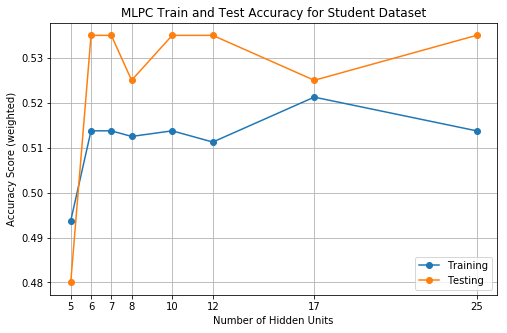


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



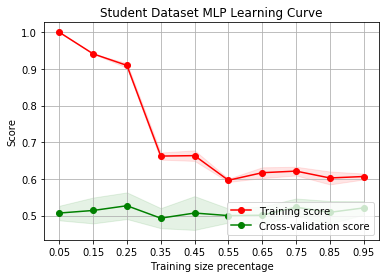


~~~~~~
Execution time metrics
Training time input dim of (800, 5) : 0.6871 (+/- 0.1459)
Testing time input dim of (200, 5): 0.0027 (+/- 0.0024)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5250 (+/- 0.0787)
Training Accuracy: 0.58875
Training F1: 0.5867989421111514
Testing Accuracy: 0.57
Testing F1: 0.5705168269230769
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


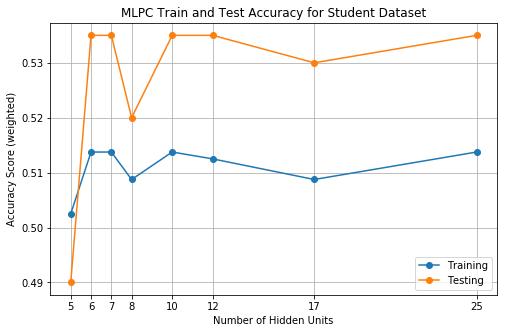


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



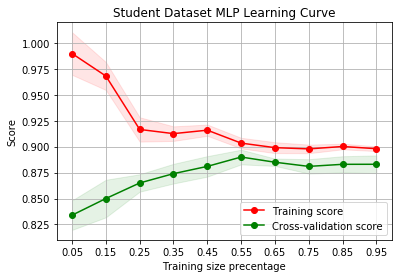


~~~~~~
Execution time metrics
Training time input dim of (800, 5) : 0.7594 (+/- 0.0976)
Testing time input dim of (200, 5): 0.0014 (+/- 0.0003)

~~~~~~
10 Fold Cross Validation Accuracy: 0.8939 (+/- 0.0519)
Training Accuracy: 0.90625
Training F1: 0.9062530782930114
Testing Accuracy: 0.875
Testing F1: 0.8750407973688834
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


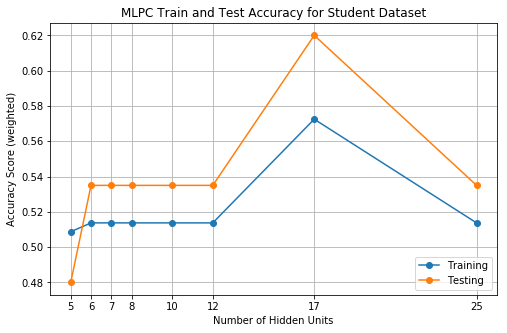


######
Testing Different Activation Functions with 10 Fold X-Val


In [5]:
for d in results:
    analysis = MLPC_Analysis(dataset=d, target='target', save=False)

    # analysis = MLPC_Analysis(dataset=df_main, target='gender', save=False)
    analysis.general_analysis()
    # analysis.max_iteration_analysis()
    analysis.hidden_layer_analysis(range_=[5,6,7,8,10,12,17,25])
    analysis.activation_analysis()

In [35]:
pd.get_dummies(df, columns=['km_clusters', 'em_clusters'])

,target,km_clusters_0,km_clusters_1,km_clusters_2,km_clusters_3,km_clusters_4,km_clusters_5,km_clusters_6,em_clusters_0,em_clusters_1,em_clusters_2,em_clusters_3,em_clusters_4,em_clusters_5,em_clusters_6
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0



######
Multilayer Perceptron Classifier:
Default Baseline values



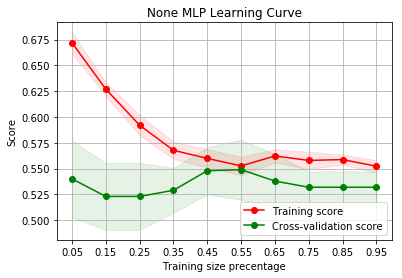


~~~~~~
Execution time metrics
Training time input dim of (800, 4) : 0.0528 (+/- 0.0033)
Testing time input dim of (200, 4): 0.0007 (+/- 0.0001)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5509 (+/- 0.0891)
Training Accuracy: 0.54875
Training F1: 0.5046218894842379
Testing Accuracy: 0.57
Testing F1: 0.5107971014492754
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


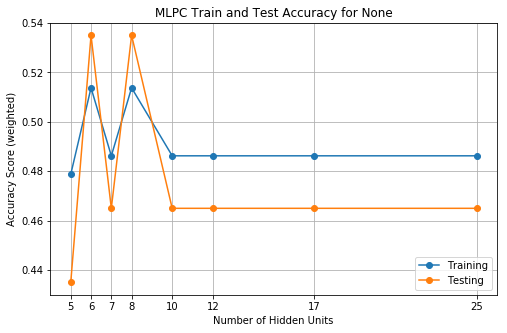


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



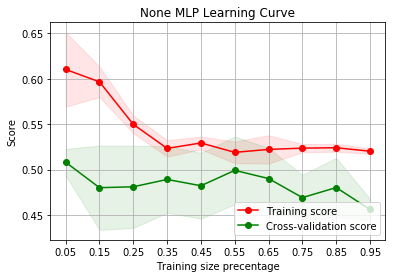


~~~~~~
Execution time metrics
Training time input dim of (800, 6) : 0.0473 (+/- 0.0062)
Testing time input dim of (200, 6): 0.0009 (+/- 0.0003)

~~~~~~
10 Fold Cross Validation Accuracy: 0.4900 (+/- 0.0610)
Training Accuracy: 0.515
Training F1: 0.5127842314251374
Testing Accuracy: 0.485
Testing F1: 0.47523791102514507
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


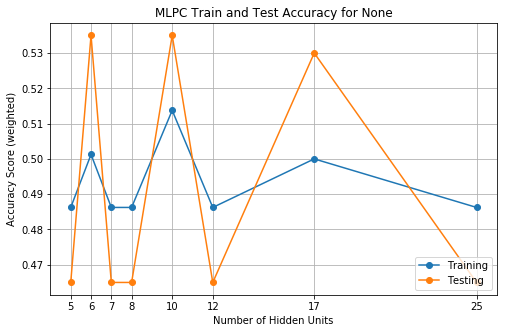


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



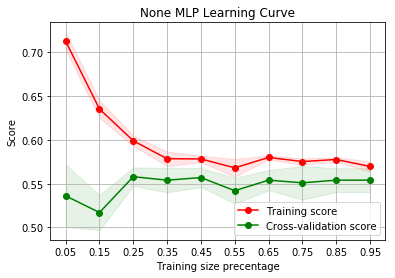


~~~~~~
Execution time metrics
Training time input dim of (800, 8) : 0.1171 (+/- 0.0186)
Testing time input dim of (200, 8): 0.0008 (+/- 0.0001)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5560 (+/- 0.1158)
Training Accuracy: 0.56125
Training F1: 0.5399364685883685
Testing Accuracy: 0.58
Testing F1: 0.542566844919786
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


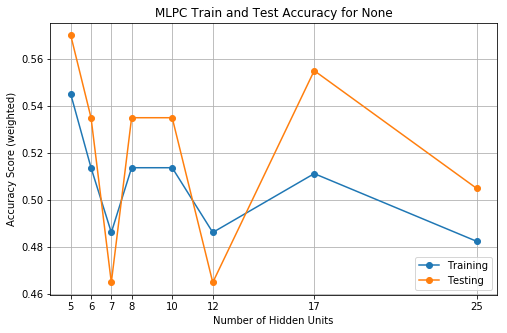


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



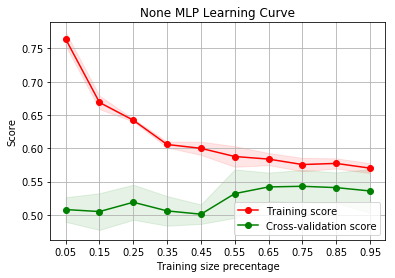


~~~~~~
Execution time metrics
Training time input dim of (800, 10) : 0.2471 (+/- 0.0300)
Testing time input dim of (200, 10): 0.0010 (+/- 0.0001)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5319 (+/- 0.1025)
Training Accuracy: 0.5725
Training F1: 0.5691786993348871
Testing Accuracy: 0.53
Testing F1: 0.5285757575757576
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


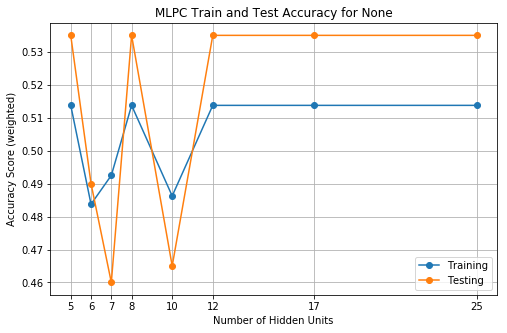


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



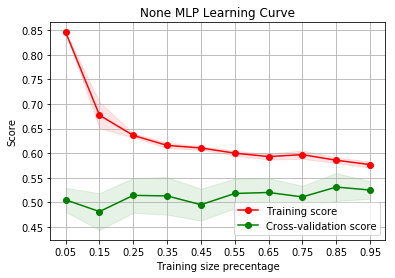


~~~~~~
Execution time metrics
Training time input dim of (800, 12) : 0.2249 (+/- 0.0159)
Testing time input dim of (200, 12): 0.0012 (+/- 0.0002)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5200 (+/- 0.1040)
Training Accuracy: 0.57875
Training F1: 0.5703751694349714
Testing Accuracy: 0.54
Testing F1: 0.5343529411764706
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


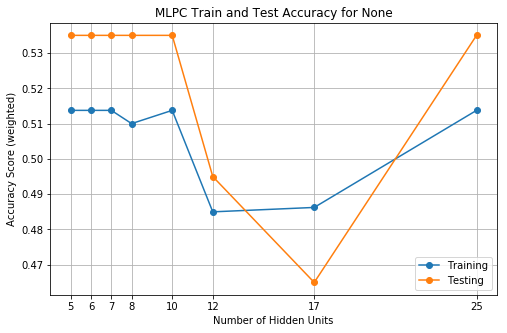


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



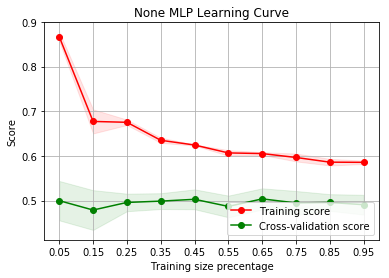


~~~~~~
Execution time metrics
Training time input dim of (800, 14) : 0.2015 (+/- 0.0215)
Testing time input dim of (200, 14): 0.0019 (+/- 0.0023)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5060 (+/- 0.0843)
Training Accuracy: 0.57375
Training F1: 0.5724145191762557
Testing Accuracy: 0.54
Testing F1: 0.5371996753246752
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


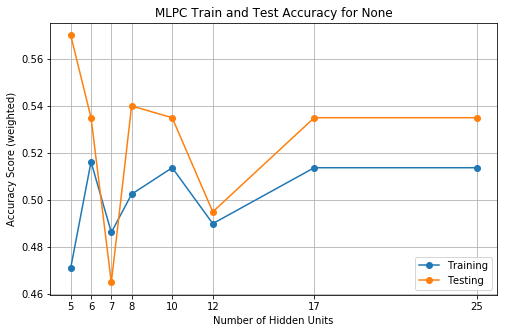


######
Testing Different Activation Functions with 10 Fold X-Val

######
Multilayer Perceptron Classifier:
Default Baseline values



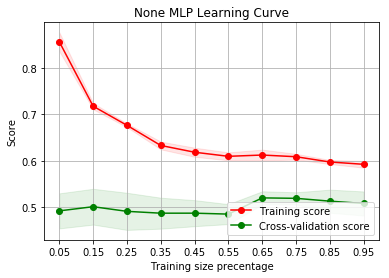


~~~~~~
Execution time metrics
Training time input dim of (800, 16) : 0.2013 (+/- 0.0105)
Testing time input dim of (200, 16): 0.0013 (+/- 0.0004)

~~~~~~
10 Fold Cross Validation Accuracy: 0.5259 (+/- 0.0911)
Training Accuracy: 0.59625
Training F1: 0.5956786834150538
Testing Accuracy: 0.515
Testing F1: 0.5116126984126983
~~~~~~


######
Testing Different Node Numbers via Alpha Parameter


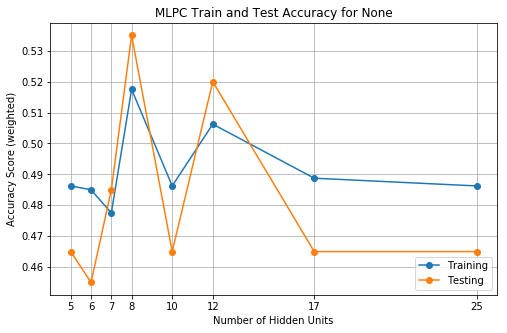


######
Testing Different Activation Functions with 10 Fold X-Val


In [38]:
# MLPC on clusters
for n in [2,3,4,5,6,7,8]:
    clusterer = KMeans(n_clusters=n, random_state=7308, n_jobs=-1)
    km_labels = clusterer.fit_predict(X_std)
    clusterer = GMM(n_components=n, random_state=7308)
    clusterer.fit(X_std)
    em_labels = clusterer.predict(X_std)

    df = pd.DataFrame(np.array([km_labels, em_labels, y_student]).T, columns=['km_clusters', 'em_clusters', 'target'])
    df_cat = pd.get_dummies(df, columns=['km_clusters', 'em_clusters'])

    analysis = MLPC_Analysis(dataset=df_cat, target='target', save=False)
    # analysis = MLPC_Analysis(dataset=df_main, target='gender', save=False)
    analysis.general_analysis()
    # analysis.max_iteration_analysis()
    analysis.hidden_layer_analysis(range_=[5,6,7,8,10,12,17,25])
    analysis.activation_analysis()